# Deep Local and Global Image Features
In this kernel I will use DELF for building a first baseline kerenl. DELF project presents code for deep local and global image feature methods, which are particularly useful for the computer vision tasks of instance-level recognition and retrieval. These were introduced in the DELF, Detect-to-Retrieve, DELG.  <br>
**Acknowledgment:** In the following link, you can find the project source code, installation guidlines and pretrained models by **@andre faraujo**: <br>
https://github.com/tensorflow/models/tree/master/research/delf

**Please upvote if you find this kernel useful**

![https://www.google.com/search?q=Deep+Local+and+Global+Image+Features&rlz=1C1GCEB_enDE900DE900&sxsrf=ALeKk01IRNDaUmMd87q0q7jM4VDHYj86Sg:1593688159103&source=lnms&tbm=isch&sa=X&ved=2ahUKEwieqeyEt67qAhUlxIUKHY6jCfwQ_AUoAXoECAwQAw&biw=1707&bih=838&dpr=1.13#imgrc=ZdwiuxwezpqU4M](attachment:image.png)
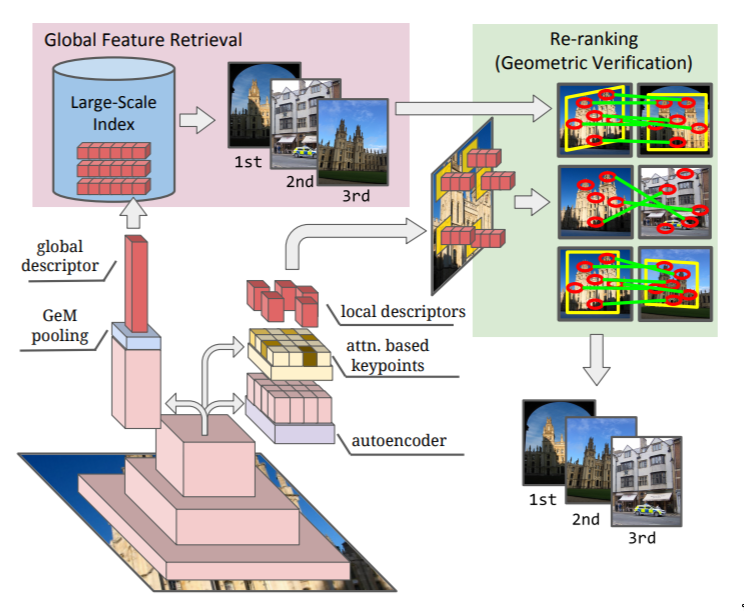

# Additional resources
* Baseline Format **@Cam Askew**: <br/>
https://www.kaggle.com/camaskew/baseline-submission/execution

* Previous winning solutions from **@Sanyam Bhutani**:<br/>
 https://www.kaggle.com/c/landmark-retrieval-2020/discussion/163287
 
* Submission Guidleines by **Andre Araujo** <br/>
 https://www.kaggle.com/c/landmark-retrieval-2020/discussion/163350

In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import tensorflow as tf
import cv2
import skimage.io
import imgaug as ia
from imgaug import augmenters as iaa
from PIL import Image
import keras.backend as K
K.set_image_data_format('channels_last')
K.set_learning_phase(1)
import seaborn as sns
import matplotlib.pyplot as plt


# Show one Example of landmark images


Taken from the public kernel...thanks for sharing this. It was quite helpful
https://www.kaggle.com/derinformatiker/landmark-retrieval-all-paths

In [ ]:
train = pd.read_csv("../input/landmark-retrieval-2020/train.csv")
def get_paths(index_location):
    index = os.listdir('../input/landmark-retrieval-2020/train/')
    paths = []
    a=index_location
    for b in index:
        for c in index:
            try:
                paths.extend([f"../input/landmark-retrieval-2020/train/{a}/{b}/{c}/" + x for x in os.listdir(f"../input/landmark-retrieval-2020/train/{a}/{b}/{c}")])
            except:
                pass

    return paths

def show_sample(pathes):
    plt.rcParams["axes.grid"] = False
    f, axarr = plt.subplots(3, 3, figsize=(20, 20))
    axarr[0, 0].imshow(cv2.imread(pathes[0]))
    axarr[0, 1].imshow(cv2.imread(pathes[1]))
    axarr[0, 2].imshow(cv2.imread(pathes[2]))
    axarr[1, 0].imshow(cv2.imread(pathes[3]))
    axarr[1, 1].imshow(cv2.imread(pathes[4]))
    axarr[1, 2].imshow(cv2.imread(pathes[5]))
    axarr[2, 0].imshow(cv2.imread(pathes[6]))
    axarr[2, 1].imshow(cv2.imread(pathes[7]))
    axarr[2, 2].imshow(cv2.imread(pathes[8]))

show_sample(get_paths(2))
#train.describe()

*********************************************************************************************************
# Data Exploration
*********************************************************************************************************

The label distribution shows clear label imbalance

In [ ]:
# Landmark ID distribution
# from https://www.kaggle.com/machinesandi/google-landmark-retrieval-2020-extensive-eda/data
fig, axs = plt.subplots(ncols=3,figsize = (20, 5))
plt.title('Category Distribuition')
sns.kdeplot(train['landmark_id'], color="tomato", shade=True, ax=axs[0])

# Occurance of landmark_id in decreasing order(Top categories)
temp = pd.DataFrame(train.landmark_id.value_counts().head(10))
temp.reset_index(inplace=True)
temp.columns = ['landmark_id','count']

plt.title('Most frequent landmarks')
sns.set_color_codes("pastel")
sns.barplot(x="landmark_id", y="count", data=temp,label="Count",ax=axs[1])

# Occurance of landmark_id in increasing order(Top categories)
temp = pd.DataFrame(train.landmark_id.value_counts().tail(8))
temp.reset_index(inplace=True)
temp.columns = ['landmark_id','count']

plt.title('Least frequent landmarks')
sns.set_color_codes("pastel")
sns.barplot(x="landmark_id", y="count", data=temp, label="Count",ax=axs[2])
plt.show()

*********************************************************************************************************
# Now lets prepare the data and train the DELF model
*********************************************************************************************************
1. Install Prerequisites
Clone the TensorFlow Model Garden repository and move into the models/research/delf/delf/python/trainingfolder:
Install TensorFlow 2.2 and TensorFlow 2.2 for GPU.
Install the TF-Slim library from source.
Download protoc and compile the DELF Protocol Buffers.
Install the matplotlib, numpy, scikit-image, scipy and python3-tk Python libraries.
Install the TensorFlow Object Detection API from the cloned TensorFlow Model Garden repository.
Install the DELF package.

In [ ]:
!git clone https://github.com/tensorflow/models.git
!bash models/research/delf/delf/python/training/install_delf.sh

In [ ]:
#In case the installation was not successful:
!cp -r models/research/delf/* ./
!protoc delf/protos/*.proto --python_out=.

2. **Prepare the Data for Training**
Preparing the data for training consists of creating TFRecord files from the raw GLDv2 images grouped into TRAIN and VALIDATION splits. The training set produced contains only the clean subset of the GLDv2 dataset. The CVPR'20 paper introducing the GLDv2 dataset contains a detailed description of the clean subset.

***For testing purpose, I am using a subset of the cleaned data. In order to use the full dataset, use:
--train_clean_csv_path=../input/cleaned-subsets-of-google-landmarks-v2/GLDv2_train_cleaned.csv** \*
  

In [ ]:
!mkdir /tmp/data
#!rm cleadn_data/*
#!ls -lh cleadn_data
!python3 delf/python/training/build_image_dataset.py \
  --train_csv_path=../input/landmark-retrieval-2020/train.csv \
  --train_clean_csv_path=../input/train-clean-sample/train_clean_sample.csv \#../input/cleaned-subsets-of-google-landmarks-v2/GLDv2_train_cleaned.csv \
  --train_directory=../input/landmark-retrieval-2020/train/*/*/*/ \
  --output_directory=/tmp/data \
  --num_shards=12 \
  --generate_train_validation_splits \
  --validation_split_size=0.2

# Running the Training
https://github.com/tensorflow/models/tree/master/research/delf <br>
For the training to converge faster, it is possible to initialize the ResNet backbone with the weights of a pretrained ImageNet model. The ImageNet checkpoint is available at the following location: http://storage.googleapis.com/delf/resnet50_imagenet_weights.tar.gz. To download and unpack it run the following commands on a Linux box:

In [ ]:
!curl -Os http://storage.googleapis.com/delf/resnet50_imagenet_weights.tar.gz
!tar -xzvf resnet50_imagenet_weights.tar.gz

Assuming the TFRecord files were generated in the gldv2_dataset/tfrecord/ directory, running the following command should start training a model and output the results in the gldv2_training directory:

In [ ]:
# add the delf to the pythonpath
os.environ['PYTHONPATH']+=':models/research/delf/:delf:protoc'
!cp -r delf/protos/*  models/research/delf/delf/protos/


In [ ]:
# installing the object detection api, required by the delf model
!pip install tensorflow-object-detection-api

In [ ]:
#-- dont forget to increase the number of iterations, default is max_iters=500.000
!cp ../input/cleancode/train2.py models/research/delf/delf/python/training/train2.py
!python3 models/research/delf/delf/python/training/train2.py \
  --train_file_pattern=/tmp/data/train* \
  --seed=1 \
  --max_iters=20000 \
  --validation_file_pattern=/tmp/data/validation* \
  --imagenet_checkpoint=resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5 \
  --dataset_version=gld_v2_clean \
  --logdir=gldv2_training/

# Exporting the Trained Model in Kaggle Format for Submission

In [ ]:
!python3 models/research/delf/delf/python/training/model/export_global_model.py \
  --ckpt_path=gldv2_training/delf_weights \
  --export_path=gldv2_model_global \
  --input_scales_list=0.70710677,1.0,1.4142135 \
  --multi_scale_pool_type=sum \
  --normalize_global_descriptor

# Testing the Trained Model
you can follow this link to test the generated model
https://github.com/tensorflow/models/tree/master/research/delf/delf/python/training

What we need to do further is using the full clean subsubset/ optimize it by augmenting the examples by excluding irrelevant positives in the training set, hyperparameterze optimizing, and use other feature extraction techniques
*********************************************************************************************************
# ****Please upvote if you find this kernel useful****
*********************************************************************************************************